# Analisando Padrões Climáticos - Ann Arbour (EUA)

Neste projeto, plotamos os padrões climáticos de Ann Arbour, Michigan, EUA (como parte do curso "Applied Plotting, Charting & Data Representation in Python" da Universidade de Michigan no Coursera).

Os dados são de um subconjunto da Rede de Climatologia Histórica Global Diária (GHCN-Daily) dos Centros Nacionais de Informações Ambientais (NCEI).

Nosso objetivo é traçar o recorde de temperaturas altas e baixas na área no período de 2005 a 2014 e observar como as temperaturas de 2015 quebram esses recordes.

Primeiro, importamos as bibliotecas que serão utilizadas no projeto:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
from IPython.display import display
from calendar import month_abbr
from matplotlib.ticker import EngFormatter, StrMethodFormatter

Depois, podemos visualizar o mapa da região de onde os dados de temperatura foram medidos. Para isso, utilizaremos o pacote `folium` para a visualização do mapa:

In [2]:
# getting the location information for this dataset
df = pd.read_csv('BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# getting longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plotting on a folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# rendering map in Jupyter
display(my_map)

Agora, carregamos os dados de temperatura no DataFrame `df`:

In [3]:
df = pd.read_csv('fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [4]:
df.describe(include = 'all')

,ID,Date,Element,Data_Value
count,165085,165085,165085,165085.000000
unique,24,4017,2,NaN
top,USC00200228,2011-12-07,TMAX,NaN
freq,8033,46,83063,NaN
mean,NaN,NaN,NaN,95.422116
std,NaN,NaN,NaN,123.515131
min,NaN,NaN,NaN,-343.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,94.000000
75%,NaN,NaN,NaN,189.000000


A temperatura nos dados está registrada como décimos de graus Celsius, portanto, é necessário fazer a conversão da temperatura:

In [5]:
# Transforming the temperature column to °C

df.columns = df.columns.str.lower()

df = df.rename(columns = {'data_value':'temperature'})

df.temperature = df.temperature * 0.1

df.head()

,id,date,element,temperature
0,USW00094889,2014-11-12,TMAX,2.2
1,USC00208972,2009-04-29,TMIN,5.6
2,USC00200032,2008-05-26,TMAX,27.8
3,USC00205563,2005-11-11,TMAX,13.9
4,USC00200230,2014-02-27,TMAX,-10.6


Com as temperaturas devidamente convertidas, podemos separar os dados em dois DataFrames diferentes, um para as temperaturas máximas `df_max` e outro para as mínimas `df_min`:

In [6]:
# Creating the minimum and maximum DataFrames

df_min = df[df.element == 'TMIN'].drop('element', axis = 1)

df_max = df[df.element == 'TMAX'].drop('element', axis = 1)

df_max.head()

,id,date,temperature
0,USW00094889,2014-11-12,2.2
2,USC00200032,2008-05-26,27.8
3,USC00205563,2005-11-11,13.9
4,USC00200230,2014-02-27,-10.6
5,USW00014833,2010-10-01,19.4


Como o objetivo do projeto é analisar o padrão de temperaturas, máximas e mínimas, durante o período 2005 - 2014 e compará-lo com o padrão de temperaturas de 2015, precisamos criar estruturas de dados separados por datas, para que seja possível determinar qual foi a temperatura máxima e mínima de cada dia do período

In [7]:
# create a DataFrame of maximum temperature by date
df_min_date = df_min.groupby('date').temperature.min().reset_index()

df_min_date['date'] = pd.to_datetime(df_min_date['date'])

df_min_date = df_min_date[~((df_min_date.date.dt.month == 2) & (df_min_date.date.dt.day == 29))].reset_index()

df_min_date['year'] = df_min_date.date.dt.year

df_min_date.date = df_min_date.date.dt.strftime('%m-%d')

df_min_date = df_min_date[['date', 'year', 'temperature']]

# create a DataFrame of minimum temperatures by date
df_max_date = df_max.groupby('date').temperature.max().reset_index()

df_max_date['date'] = pd.to_datetime(df_max_date['date'])

df_max_date = df_max_date[~((df_max_date.date.dt.month == 2) & (df_max_date.date.dt.day == 29))].reset_index()

df_max_date['year'] = df_max_date.date.dt.year

df_max_date.date = df_max_date.date.dt.strftime('%m-%d')

df_max_date = df_max_date[['date', 'year', 'temperature']]

In [8]:
df_min_date

,date,year,temperature
0,01-01,2005,-5.6
1,01-02,2005,-5.6
2,01-03,2005,0.0
3,01-04,2005,-3.9
4,01-05,2005,-9.4
...,...,...,...
4010,12-27,2015,-0.6
4011,12-28,2015,-3.9
4012,12-29,2015,-3.9
4013,12-30,2015,-2.2


Temos agora 2 DataFrames com informações de temperaturas máximas e mínimas, para cada dia entre 2005 e 2015. 

Queremos agora, estabelecer quais foram as temperaturas máximas e minimas de cada dia do ano, para os anos 2005-2014, de forma que seja possível estabelecer o padrão de temperaturas para o período. Iremos armazenar essas informações no DataFrame `df_min_05_14` e `df_max_05_14`.

Por fim, também iremos armazenar as temperaturas máximas e mínimas de 2015 para compará-las com o padrão histórico entre 2005 e 2014. Vamos guardar essas informações nos DataFrames `df_min_2015` e `df_max_2015`.

In [9]:
# calculate the minimum and maximum values for the day of the year for 2005 through 2014
df_min_05_14 = df_min_date[df_min_date.year != 2015].groupby('date').temperature.min().reset_index()

df_max_05_14 = df_max_date[df_min_date.year != 2015].groupby('date').temperature.max().reset_index()

# calculate the minimum and maximum values for the years 2015

df_min_2015 = df_min_date[df_min_date.year == 2015].reset_index().drop('index', axis = 1)

df_max_2015 = df_max_date[df_max_date.year == 2015].reset_index().drop('index', axis = 1)

In [10]:
df_min_05_14.head()

,date,temperature
0,01-01,-16.0
1,01-02,-26.7
2,01-03,-26.7
3,01-04,-26.1
4,01-05,-15.0


Para que seja possível visualizar em quais dias de 2015 as temperaturas bateram um recorde (de mínimo ou máximo) em relação às temperaturas do período 2005 - 2014, vamos realizar uma comparação entre os valores de temperaturas dos DataFrames e armazenar os dias com temperatura recorde nas listas `record_low` e `record_high`.

In [11]:
record_low = []
record_high = []

for t_05_14, t_15 in zip(df_min_05_14.temperature, df_min_2015.temperature):
    if t_15 < t_05_14:
        record_low.append(t_15)
    else:
        record_low.append(np.nan)

for t_05_14, t_15 in zip(df_max_05_14.temperature, df_max_2015.temperature):
    if t_15 > t_05_14:
        record_high.append(t_15)
    else:
        record_high.append(np.nan)

Por fim, criamos o gráfico. Usamos um gráfico de linhas vermelhas e azuis para plotar os registros de temperaturas altas e baixas de 2005 a 2015. Em seguida, sobrepomos um gráfico de dispersão para exibir os pontos de dados de 2015 que excedem esses registros.

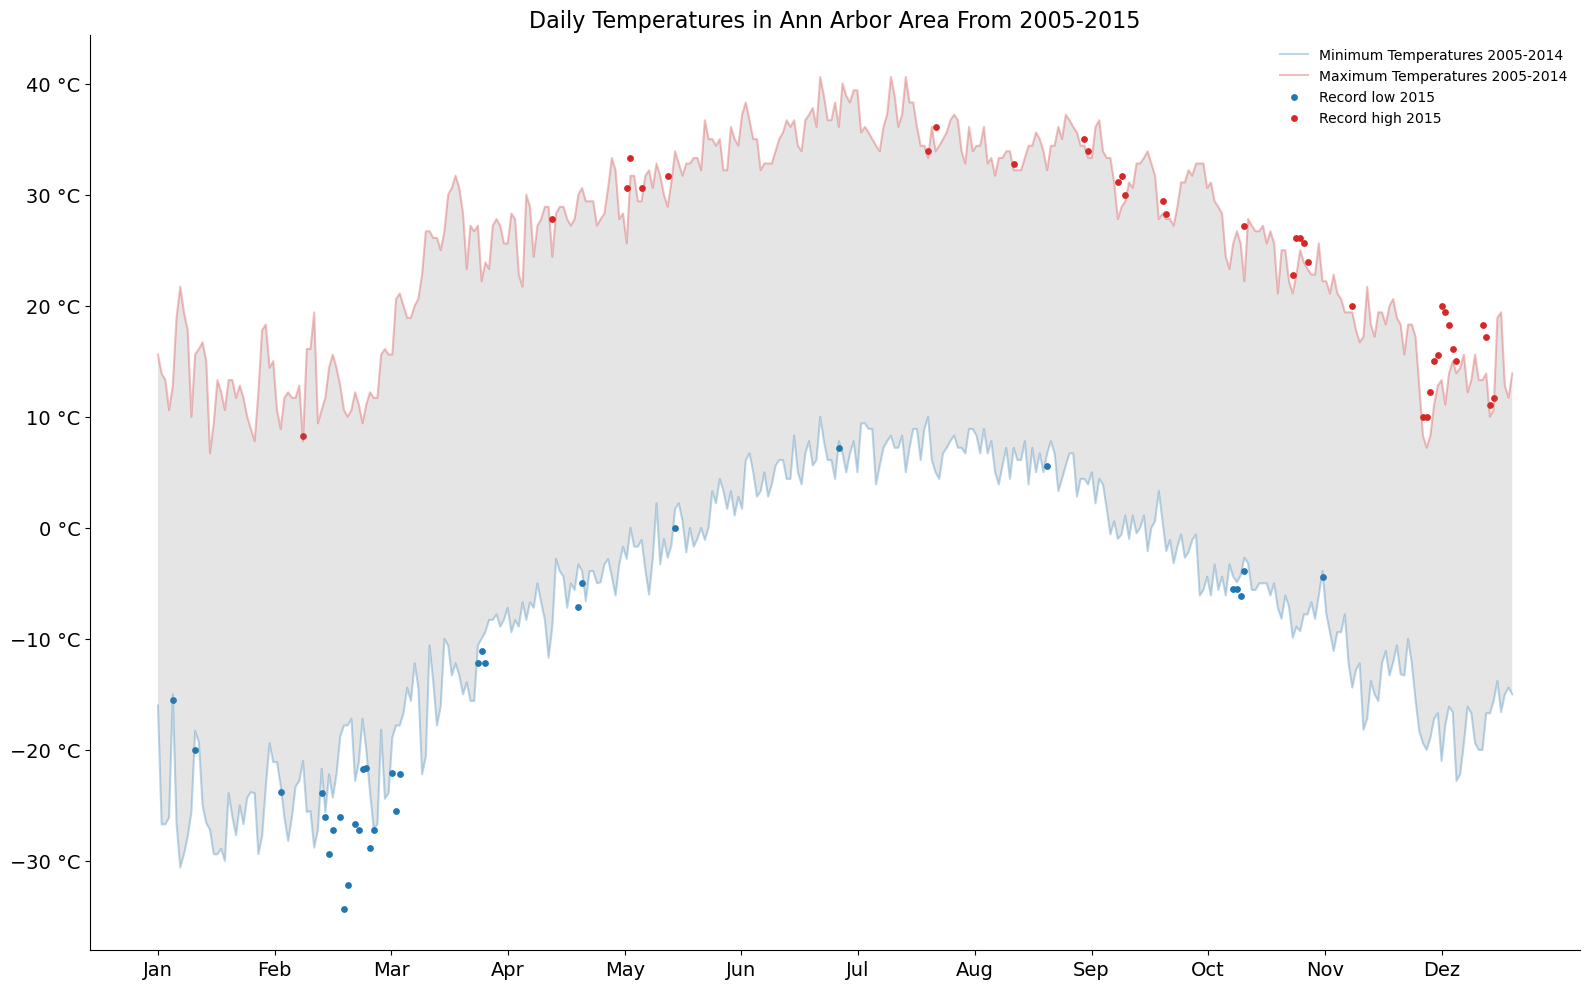

In [12]:
plt.figure(figsize = (16,10))

plt.plot(df_min_05_14.temperature, '-', label = 'Minimum Temperatures 2005-2014', c = 'tab:blue', alpha = 0.3)
plt.plot(df_max_05_14.temperature, '-', label = 'Maximum Temperatures 2005-2014', c = 'tab:red', alpha = 0.3)
plt.scatter(np.arange(365), record_low, label = 'Record low 2015', c = 'tab:blue', s = 15)
plt.scatter(np.arange(365), record_high, label = 'Record high 2015', c = 'tab:red', s = 15)

plt.legend(frameon=False)

plt.gca().yaxis.set_major_formatter(EngFormatter(unit=u"°C"))
plt.yticks(fontsize = 14)
plt.gca().fill_between(range(len(df_min_05_14.temperature)), df_min_05_14.temperature, df_max_05_14.temperature, facecolor = 'grey', alpha = 0.2)
plt.xticks(np.linspace(0, 15 + 30*11, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dez'], fontsize=14)

plt.title('Daily Temperatures in Ann Arbor Area From 2005-2015', fontsize = 16)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('temperatures.png')

Observando o gráfico, podemos ver que em 2015 tivemos vários dias em que a temperatura bateu recordes. O perído entre dezembro e março apresenta o maior número de dias com temperaturas recorde, sugerindo que a região está tendo temperaturas mais extremas no verão, em relação às outras estações do ano.